# OWG Policy in Pybullet

In [3]:
cd ..

/home/p300488/LMM_utils/LMM-grasp-anything/OWG


In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyBboxPatch
from pprint import pprint

# helper function
%matplotlib inline
def display_image(path_or_array, size=(10, 10)):
  if isinstance(path_or_array, str):
    image = np.asarray(Image.open(open(image_path, 'rb')).convert("RGB"))
  else:
    image = path_or_array
  
  plt.figure(figsize=size)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

## Setup Pybullet Env

In [5]:
from owg_robot.env import *
from owg_robot.camera import Camera
from owg_robot.objects import YcbObjects

pybullet build time: Nov 28 2023 23:52:03


In [6]:
#p.disconnect()

# load camera and env
center_x, center_y, center_z = CAM_X, CAM_Y, CAM_Z
camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (448, 448), 40)
env = Environment(camera, vis=True, asset_root='./owg_robot/assets', debug=False, finger_length=0.06)

# load objects
objects = YcbObjects('./owg_robot/assets/ycb_objects',
                    mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                    mod_stiffness=['Strawberry'],
                    seed=42
)
objects.shuffle_objects()

n_objects = 12

for obj_name in objects.obj_names[:n_objects]:
    path, mod_orn, mod_stiffness = objects.get_obj_info(obj_name)
    env.load_isolated_obj(path, obj_name, mod_orn, mod_stiffness)
env.dummy_simulation_steps(10)

In [7]:
from third_party.grconvnet import *
from owg.utils.grasp import Grasp2D

grasp_generator = load_grasp_generator(camera)

INFO:root:CUDA detected. Running with GPU acceleration.


224 224


<Figure size 1000x1000 with 0 Axes>

In [8]:
def setup_grasps(env, grasp_generator, visualise_grasps=False):
        rgb, depth, seg = env.camera.get_cam_img()    
        img_size = grasp_generator.IMG_WIDTH
        if  img_size != camera.width: 
            rgb = cv2.resize(rgb, (img_size, img_size))
            depth = cv2.resize(depth, (img_size, img_size))
        for obj_id in env.obj_ids:
            mask = seg == obj_id
            if img_size != camera.width:
                mask = np.array(Image.fromarray(mask).resize((img_size, img_size), Image.LANCZOS))
            grasps, grasp_rects = grasp_generator.predict_grasp_from_mask(rgb,
                                                           depth,
                                                           mask,
                                                           n_grasps=5, 
                                                           show_output=True
            )
            if img_size != camera.width:
                # normalize to original size
                for j, gr in enumerate(grasp_rects):
                    grasp_rects[j][0] = int(gr[0] / img_size * camera.width)
                    grasp_rects[j][1] = int(gr[1] / img_size * camera.width)
                    grasp_rects[j][4] = int(gr[4] / img_size * camera.width)
                    grasp_rects[j][3] = int(gr[3] / img_size * camera.width)
            grasp_rects = [Grasp2D.from_vector(
                x=g[1], y=g[0], w=g[4], h=g[3], theta=g[2], W=camera.width, H=camera.width, normalized=False, line_offset=5,
            ) for g in grasp_rects]
            env.set_obj_grasps(obj_id, grasps, grasp_rects)
        
        if visualise_grasps:
            LID =[]
            for obj_id in env.obj_ids:
                grasps = env.get_obj_grasps(obj_id)
                color = np.random.rand(3).tolist()
                for g in grasps:
                    LID = env.draw_predicted_grasp(g,color=color,lineIDs=LID)
            
            time.sleep(1)
            env.remove_drawing(LID)
            env.dummy_simulation_steps(10)

In [9]:
# run and visualize grasps -- check in your Pybullet client
setup_grasps(env, grasp_generator, visualise_grasps=True)

<Figure size 640x480 with 0 Axes>

In [10]:
obs = env.get_obs()

all_grasp_rects = {k: env.get_obj_grasp_rects(k) for k in env.obj_ids }

## Referring Segmentation

In [10]:
import os
os.environ['OPENAI_API_KEY'] = 'your OpenAI api key here' 

In [12]:
from owg.visual_prompt import VisualPrompterGrounding, VisualPrompterPlanning, VisualPrompterGraspRanking

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [13]:
config_path = 'config/pyb/OWG.yaml'

In [14]:
grounder = VisualPrompterGrounding(config_path, debug=True)

In [15]:
image, seg = obs['image'], obs['seg']
obj_ids = np.unique(seg)[1:]
all_masks = np.stack([seg == objID for objID in obj_ids])
marker_data = {'masks': all_masks, 'labels': obj_ids}

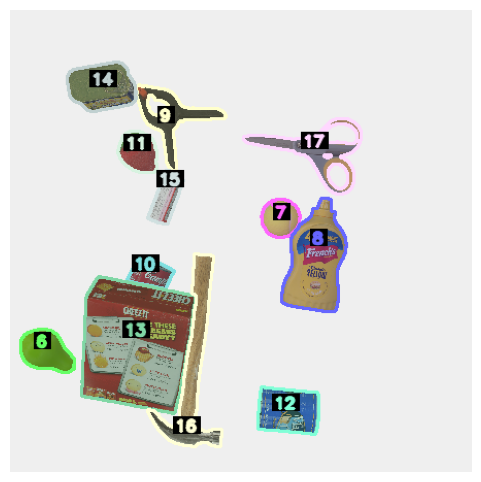

In [16]:
# show visual prompt
visual_promppt, _ = grounder.prepare_image_prompt(image.copy(), marker_data)
marked_image_grounding = visual_promppt[-1]
display_image(marked_image_grounding, (6,6))

In [17]:
# GPT request
user_query = "I want to cut some paper"

dets, target_mask, target_ids = grounder.request(text_query=user_query,image=image.copy(),data=marker_data)

GPT response:
To cut some paper, you would need scissors. In the image, the scissors are located towards the top right.

The ID for the scissors is 17.

My final answer is: [17]



17


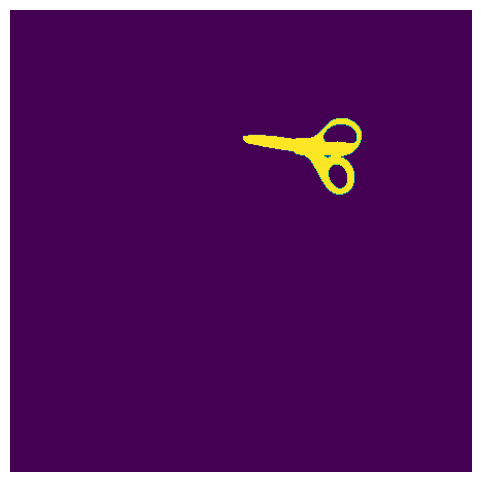

In [18]:
target_id = target_ids[0] # assume single correct object
print(target_id)
display_image(target_mask, (6,6))

## Grasp Planning

In [19]:
planner = VisualPrompterPlanning(config_path, debug=True)

In [20]:
plan = planner.request(text_query=target_id,
                                    image=image.copy(),
                                    data=marker_data)
action = plan[0]

GPT response:
Plan:
```json
[
  {"action": "pick", "input": 17}
]
```



In [21]:
action

{'action': 'pick', 'input': 17}

## Grasp Ranking

In [22]:
grasp_ranker = VisualPrompterGraspRanking(config_path, debug=True)

In [23]:
obj_grasps = all_grasp_rects[action['input']]
obj_mask = all_masks[env.obj_ids.index(action['input'])]
req_data = {'grasps': obj_grasps, 'mask': obj_mask}

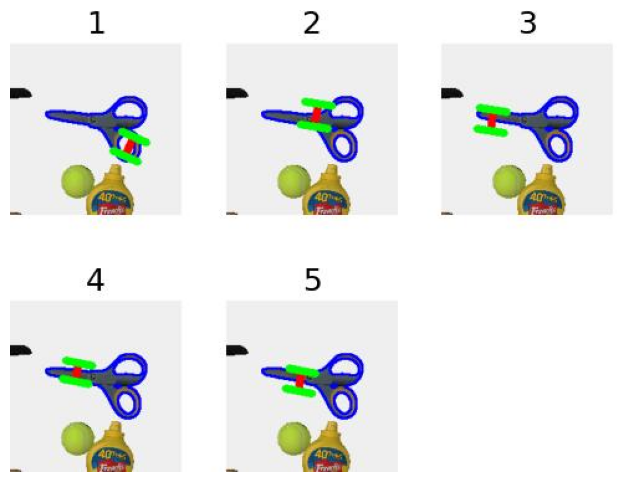

In [24]:
# show visual prompt
visual_prompt, _ = grasp_ranker.prepare_image_prompt(image.copy(), req_data)
marked_image_grasping = visual_prompt[-1]
display_image(marked_image_grasping, (12,6))

In [25]:
sorted_grasps, best_grasp, sorted_grasp_indices = grasp_ranker.request(image.copy(), req_data)

GPT response:
1) The object of interest is a pair of blue scissors. The surrounding objects are a green ball and a bottle labeled "40% Faster."

2) Grasp poses leading to contacts:
   - Pose 1: Contact with the bottle.
   - Pose 2: No contact.
   - Pose 3: No contact.
   - Pose 4: No contact.
   - Pose 5: Contact with the bottle.

3) Ranking of grasp poses from best to worst:
   - Pose 3: Centered and no contact.
   - Pose 2: Slightly off-center but no contact.
   - Pose 4: Slightly off-center but no contact.
   - Pose 1: Contact with the bottle.
   - Pose 5: Contact with the bottle.

My final answer is: [3, 2, 4, 1, 5].



In [26]:
action['grasps'] = sorted_grasp_indices

In [27]:
        # take step
        if action['action'] == 'remove':
            success_grasp, success_target = env.put_obj_in_free_space(
                action['input'], grasp_indices=action['grasps'])
        elif action['action'] == 'pick':
            success_grasp, success_target = env.put_obj_in_tray(
                action['input'], grasp_indices=action['grasps'])
        for _ in range(30):
            env.step_simulation()
        print(success_grasp, success_target)

True True


In [28]:
p.disconnect()